# Snow Micro Pen Analysis Notebook

This notebook uses the snowmicropyn library to aggregate and and analyse force profiles from the snow micro pen.

Documentation here: https://snowmicropyn.readthedocs.io
Sample data can be downloaded here: https://data.aad.gov.au/metadata/AAS_4496_SMP_23

## Imports and functions

In [1]:
from snowmicropyn import Profile
import matplotlib.pyplot as plt
import sys
import glob
import pandas as pd
from pathlib import Path
import geopandas as gpd
from snowmicropyn import proksch2015
from snowmicropyn.parameterizations.king2020 import King2020a
import os
from tqdm.notebook import tqdm

In [2]:
def pnt_reader(pnt_path):

    """
    Read and process a PNT file to extract profile information.

    This function loads a PNT file using the Profile class, calculates various parameters such as mean specific surface area (SSA) and mean density within markers, and returns a pandas Series containing extracted information.

    If you want to use different paremeretisations for calculation snow density etc refer to the snowmicropyn documentation

    Parameters:
    pnt_path (str): Path to the PNT file.

    Returns:
    series (pandas.Series): A pandas Series containing profile information including filename, latitude, longitude, timestamp, depth, mean SSA, and mean density.

    Example:
    >>> profile_info = pnt_reader('/path/to/profile.pnt')
    """

    p = Profile.load(pnt_path)
    
    p2015 = proksch2015.calc(p.samples)
    
    p.set_marker('surface', p.detect_surface())
    p.set_marker('ground', p.detect_ground())
    
    # print('Markers: {}'.format(p.markers))
    
    surface = p.marker('surface')
    ground = p.marker('ground')
    
    layer = p2015[p2015.distance.between(surface, ground)]
    
    # Calculate mean SSA within markers
    # print('Mean SSA within markers: {:.1f} m^2/m^3'.format(layer.P2015_ssa.mean()))
    
    # Calculate mean density within markers
    
    density = layer.P2015_density.mean()
    # print('Density: {:.0f} kg/m^3'.format(density))
    
    depth = ground-surface
    
    series = pd.Series(
        {
            "Filename": os.path.basename(pnt_path),
            "Latitude": p.coordinates[0],
            "Longitude": p.coordinates[1],
            "Timestamp": p.timestamp,
            "Depth":depth,
            "MeanSSA": layer.P2015_ssa.mean(),
            "MeanDensity":layer.P2015_density.mean(),
            
        }
    )

    return series

def pnt_summary(pnt_path):

    """
    Generate a summary GeoDataFrame from a directory of PNT files.

    This function reads PNT files from the specified directory, calculates various parameters including mean specific surface area (SSA) and mean density within markers on each profile, and compiles them into a summary GeoDataFrame.

    Parameters:
    pnt_path (str): Path to the directory containing PNT files.

    Returns:
    gdf (GeoDataFrame): Summary GeoDataFrame containing information extracted from the PNT files including filename, latitude, longitude, timestamp, depth, mean SSA, and mean density.

    Example:
    >>> summary_df = pnt_summary('/path/to/pnt/files')
    """
    
    pnt_list = []
    for f in tqdm(sorted(Path(pnt_path).rglob('*.PNT*'))):
        # print(f)
        series = pnt_reader(f)
        pnt_list.append(series)
    df = pd.concat(pnt_list, axis=1).T
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
    )
    return gdf


## Single PNT example

Load one PNT file and plot the force profile

<AxesSubplot:xlabel='distance'>

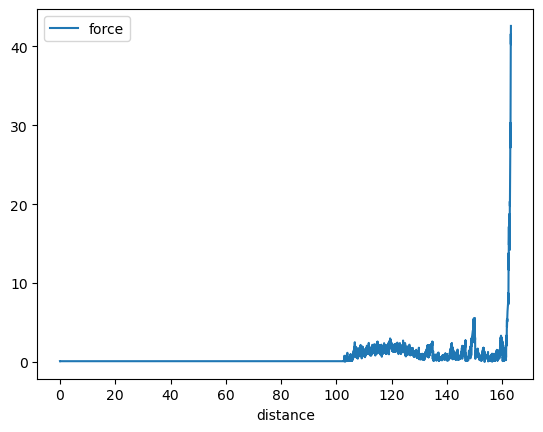

In [4]:
pnt = '/g/data/jk72/sc0554/K892B/SMP/clean_archive/S54M0475.PNT'
p = Profile.load(pnt)
ts = p.timestamp
coords = p.coordinates
samples = p.samples  # It's a pandas dataframe
samples.plot.line(x='distance',y='force')

In [18]:
# Export single profile derivatives

p.export_derivatives(file = '/g/data/jk72/sc0554/K892B/SM54M0084.csv')

PosixPath('/g/data/jk72/sc0554/K892B/SM54M0084.csv')

## Clean invalid measurements

In [6]:
# When given a folder path containing PNTs this loop will create a list of measurements with invalid lat / lon, this occurs if the GPS didn't connect correctly. If you have an alternative way of finding a gps location you can manually amend it or you can still view the force profile.

# These lists can be used for data cleaning purposes if desired.

pnt_path = '/g/data/jk72/sc0554/K892B/SMP/all_archive/'

pnt_list = []
exclude = []
for f in tqdm(sorted(Path(pnt_path).rglob('*.PNT*'))):
    p = Profile.load(f)
    # REMOVE MEASUREMENTS WITH NO LAT / LON
    if p.coordinates == None:
        exclude.append(f.name)
    if f.name not in exclude:
        pnt_list.append(f.name)

  0%|          | 0/509 [00:00<?, ?it/s]

Latitude value -100329.0 invalid, replacing by None (file S54M0000)
Longitude value None invalid, replacing by None (file S54M0000)
Latitude value -100329.0 invalid, replacing by None (file S54M0001)
Longitude value None invalid, replacing by None (file S54M0001)
Latitude value -100329.0 invalid, replacing by None (file S54M0002)
Longitude value None invalid, replacing by None (file S54M0002)
Latitude value -100329.0 invalid, replacing by None (file S54M0003)
Longitude value None invalid, replacing by None (file S54M0003)
Latitude value -100329.0 invalid, replacing by None (file S54M0004)
Longitude value None invalid, replacing by None (file S54M0004)
Latitude value -100329.0 invalid, replacing by None (file S54M0005)
Longitude value None invalid, replacing by None (file S54M0005)
Latitude value -100329.0 invalid, replacing by None (file S54M0007)
Longitude value None invalid, replacing by None (file S54M0007)
Unable to build timestamp from pnt header fields


In [10]:
print("measurements without valid lat/lon", len(exclude))
print("Number of valid measurements", len(pnt_list))

measurements without valid lat/lon 8
Number of valid measurements 501


## Create SMP summary

In [11]:
# Create a dataframe containing simplifed data of all PNT files in a folder

pnt_path = '/g/data/jk72/sc0554/K892B/SMP/clean_archive/'

df = pnt_summary(pnt_path)

  0%|          | 0/501 [00:00<?, ?it/s]

/g/data/gv90/sc0554/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/snowmicropyn/parameterizations/proksch2015.py:42: RuntimeWarning: invalid value encountered in log
  return aa[0] + aa[1] * np.log(F_m) + aa[2] * np.log(F_m) * LL + aa[3] * LL
/g/data/gv90/sc0554/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/snowmicropyn/parameterizations/proksch2015.py:58: RuntimeWarning: invalid value encountered in log
  lc = cc[0] + cc[1] * LL + cc[2] * np.log(F_m)


In [4]:
# Example of how to remove unwanted measurements, add more filenames to the drop list to remove multiples.
drop = ['S54M0006.PNT']
df = df[~df['Filename'].isin(drop)]

In [15]:
df[[S54M0006.PNT

,Filename,Latitude,Longitude,Timestamp,Depth,MeanSSA,MeanDensity,geometry
0,S54M0006.PNT,-42.986893,147.292511,2023-10-03 03:46:43+00:00,82.907021,30.091065,247.106919,POINT (147.29251 -42.98689)
1,S54M0008.PNT,-77.861343,166.762299,2023-11-07 21:47:10+00:00,50.894626,31.391912,218.055411,POINT (166.76230 -77.86134)
2,S54M0009.PNT,-77.861351,166.762268,2023-11-07 21:52:19+00:00,101.1095,7.974856,489.851621,POINT (166.76227 -77.86135)
3,S54M0010.PNT,-77.861359,166.762283,2023-11-07 21:54:52+00:00,256.518584,7.842651,476.938379,POINT (166.76228 -77.86136)
4,S54M0011.PNT,-77.861359,166.762253,2023-11-07 22:06:23+00:00,227.022718,5.871665,538.307908,POINT (166.76225 -77.86136)
...,...,...,...,...,...,...,...,...
496,S54M0504.PNT,-77.874588,166.419754,2023-11-22 01:07:21+00:00,71.535121,7.592774,352.446143,POINT (166.41975 -77.87459)
497,S54M0505.PNT,-77.874588,166.419724,2023-11-22 01:07:46+00:00,56.394626,7.499484,364.017048,POINT (166.41972 -77.87459)
498,S54M0506.PNT,-77.874588,166.419662,2023-11-22 01:08:11+00:00,39.398759,7.648172,358.548537,POINT (166.41966 -77.87459)
499,S54M0507.PNT,-77.87458,166.419632,2023-11-22 01:08:44+00:00,26.369834,7.020693,287.213641,POINT (166.41963 -77.87458)


In [5]:
# This provides a spatial view of all the measurement points in the dataframe. Timestamp must be removed for this to work correctly
df.drop(columns='Timestamp').explore()

In [34]:
# You can save the df to a csv 

df.to_csv('SMP_Measurements.csv')

## Method for copying PNT files between folders based on filenames in saved CSV

In [12]:
SMP_metadata = pd.read_csv('/g/data/jk72/sc0554/K892B/SMP/clean_archive/SCOTTBASESMPMEASUREMENTS_v2.csv')
valid_files = list(SMP_metadata['Filename'])

In [75]:
import os
import shutil
src = '/g/data/jk72/sc0554/K892B/SMP/clean_archive/'
dst = '/g/data/jk72/sc0554/K892B/SMP/AADC_final_archive/'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.basename(file_name) in valid_files:
        shutil.copy(full_file_name, dst)

## Convert PNT files to csv

In [14]:
# This creates three csvs of the force profiles, metadata and the derived data
path = '/path/to/PNTS'
pnt_list = []
for f in tqdm(sorted(Path(path).rglob('*.PNT*'))):
    p = Profile.load(f)
    p.export_samples()
    p.export_meta(include_pnt_header=True)
    p.export_derivatives()